This is done following tutorial by https://towardsdatascience.com/evolving-neural-networks-b24517bb3701

## Organism

In [235]:
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
class Organism():
    def __init__(self, dimensions, use_bias=True, output='softmax'):
        #dimensions = [1,12,12,12,2]
        self.layers = []
        self.biases = []
        self.use_bias = use_bias
        self.output = self._activation(output)
        for i in range(len(dimensions)-1):
            shape = (dimensions[i],dimensions[i+1])
            std = np.sqrt(2/sum(shape))
            self.layers.append(np.random.normal(0,std,shape))
            self.biases.append(np.random.normal(0,std,(1,shape[1])))
            
            

    def _activation(self, output):
        if output == 'softmax':
            return lambda X : np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
        if output == 'sigmoid':
            return lambda X : (1 / (1 + np.exp(-X)))
        if output == 'linear':
            return lambda X : X
    def predict(self, X_in):
        X = copy.deepcopy(X_in)
        for index, (layer, bias) in enumerate(zip(self.layers,self.biases)):
            if self.use_bias:

                X = np.dot(np.append(X,np.ones((X.shape[0],1)),axis=1),np.append(layer,bias,axis=0))
            else:
                X = np.dot(X,layer)
            if index < len(self.layers)-1:
                X = np.clip(X,0,np.inf) #ReLU for all internal layers
            else:
                ''
        return self.output(X)

    def mutate(self,stdev=0.03):
        for i in range(len(self.layers)):
            self.layers[i] += np.random.normal(0,stdev,self.layers[i].shape)
            if self.use_bias:
                self.biases[i] += np.random.normal(0,stdev,self.biases[i].shape)
    def mate(self,other,mutate=True):
        if self.use_bias != other.use_bias:
            raise ValueError('Both parents must use bias or not use bias')
        if len(self.layers) != len(other.layers):
            raise ValueError('Both parents must have the same number of layers')
        if not all([self.layers[i].shape == other.layers[i].shape for i in range(len(self.layers))]):
            raise ValueError('All layers must the same shapes for both parents')
        child = copy.deepcopy(self)
        for i in range(len(child.layers)):
            pass_on = np.random.rand(1,child.layers[i].shape[1]) < 0.5 #randomly choose column
            child.layers[i] = pass_on*child.layers[i] + ~pass_on*other.layers[i]
            child.biases[i] = pass_on*child.biases[i] + ~pass_on*other.biases[i]
        if mutate:
            child.mutate()
        return child

## Ecosystem

In [212]:
class Ecosystem():
    def __init__(self, original_f, scoring_function, population_size=100, holdout='sqrt', mating=True):
        '''
        original_f is the function to create Organisms
        scoring_function accepts an Organism as input and return a float score
        holdout is the number of organisms that are guaranteed progeny. Can be 'sqrt', 'log', a fraction, or an integer
        '''
        self.population_size = population_size
        self.population = [original_f() for _ in range(population_size)]
        
        self.scoring_function = scoring_function
        self.scores = [self.scoring_function(x) for x in self.population]
        if holdout=='sqrt': #sqrt of the population size
            self.holdout = max(1,int(np.sqrt(population_size)))
        elif holdout=='log': #log of the population size
            self.holdout = max(1,int(np.log(population_size)))
        elif holdout > 0 and holdout < 1: #as a fraction
            self.holdout = max(1,int(holdout*population_size))
        else: #number of individual
            self.holdout = max(1,int(holdout))
        self.mating=mating
    def generation(self, repeats=1, keep_best=True):
        rewards = self.scores
        self.population = [self.population[x] for x in np.argsort(rewards)[::-1]]
        new_population = []
        for i in range(self.population_size):
            parent1_idx = i % self.holdout
            if self.mating:
                parent2_idx = min(self.population_size-1,int(np.random.exponential(self.holdout))) #sample from exponential dist. No bigger than the last index
            else:
                # asexual reproduction
                parent2_idx = parent1_idx
            #mate the parents
            offspring = self.population[parent1_idx].mate(self.population[parent2_idx])
            #add to new population
            new_population.append(offspring)
        if keep_best:
            # keep the best in the population. Replace with the last in population
            new_population[-1] = self.population[0]
        self.population = new_population
        self.scores = [self.scoring_function(x) for x in self.population]
    def get_best_organism(self, include_reward=False):
        rewards = self.scores
        best_idx = np.argsort(rewards)[-1]        
        if include_reward:
            return self.population[best_idx], rewards[best_idx]
        else:
            return self.population[best_idx]

## Regression

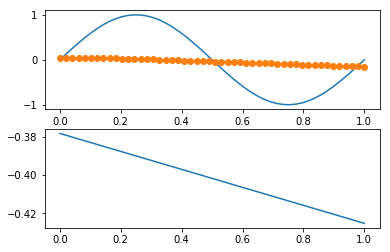

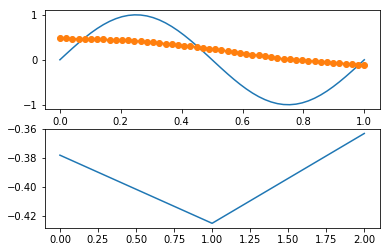

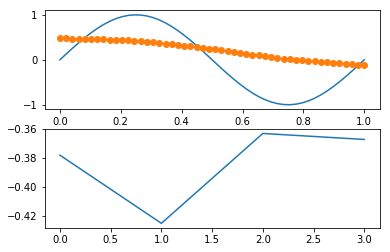

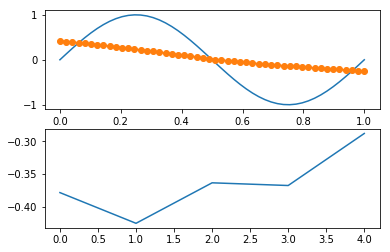

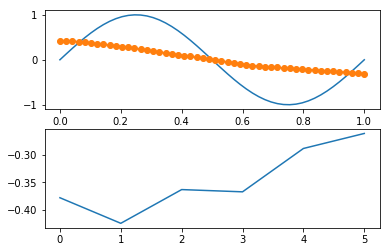

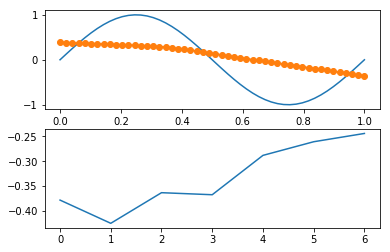

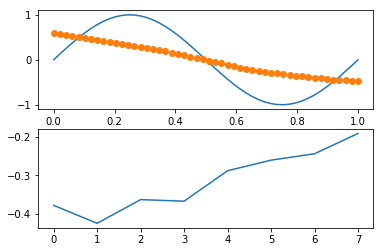

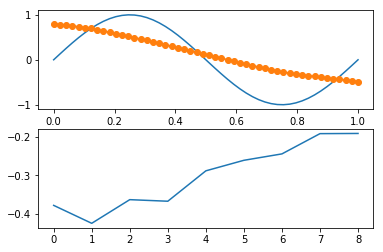

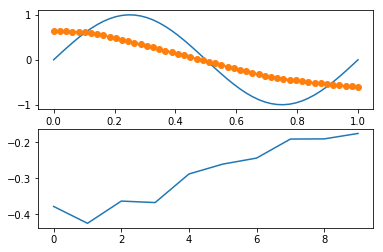

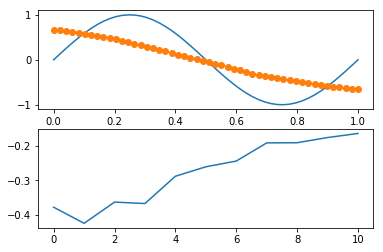

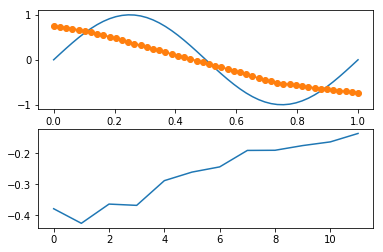

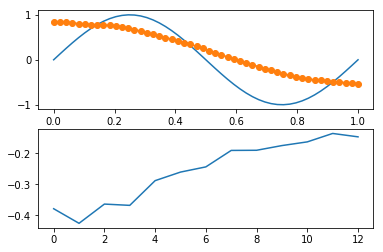

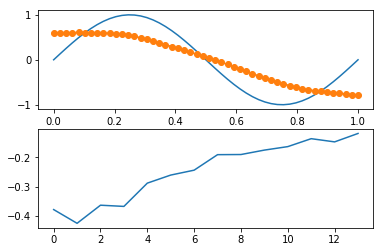

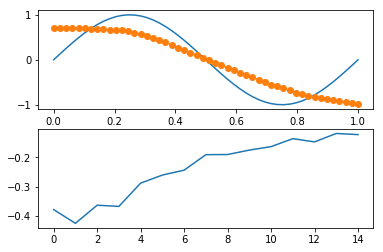

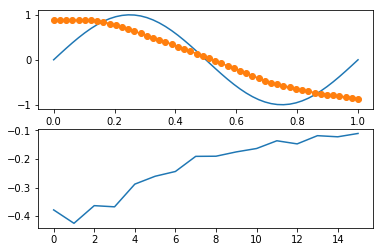

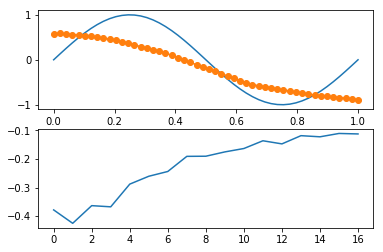

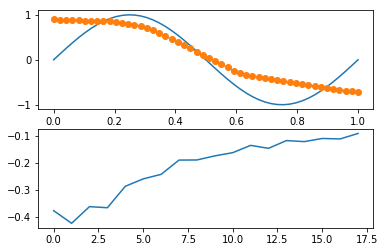

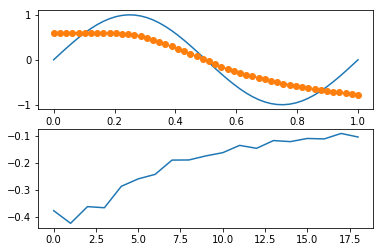

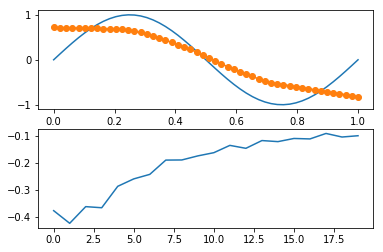

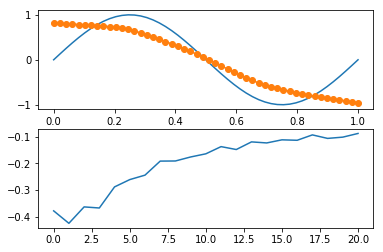

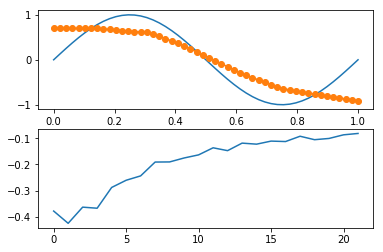

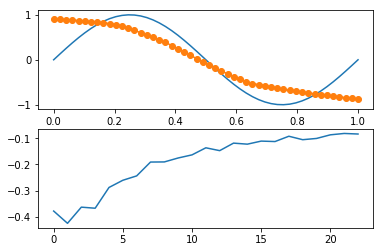

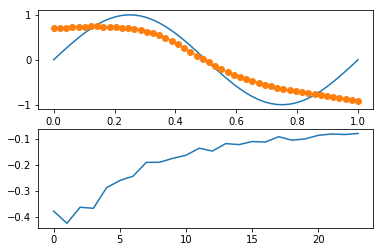

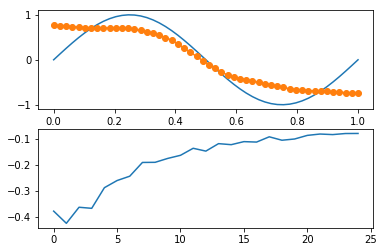

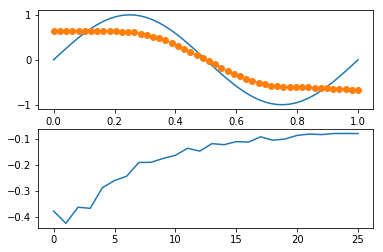

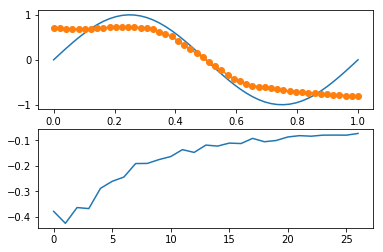

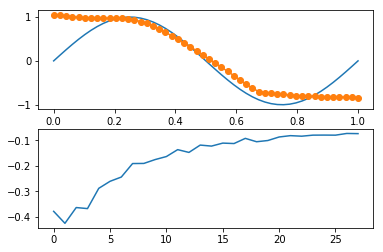

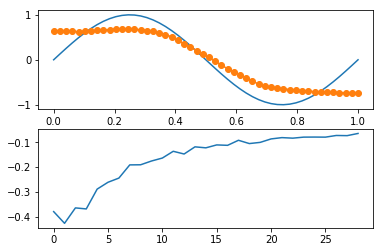

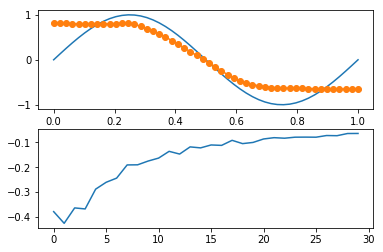

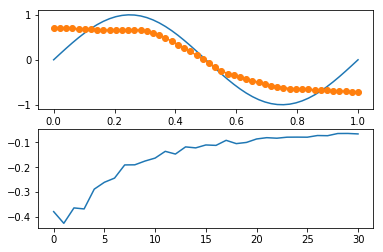

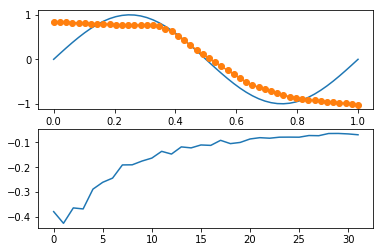

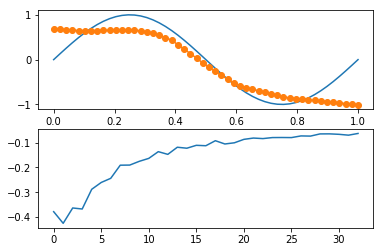

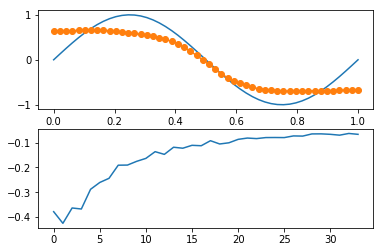

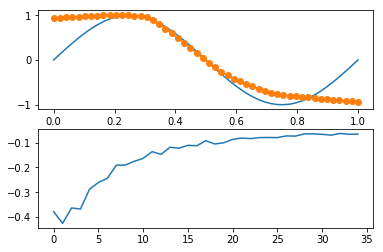

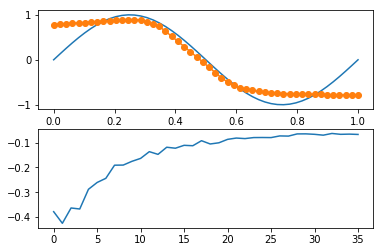

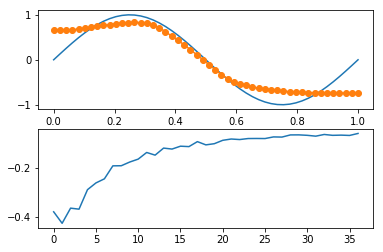

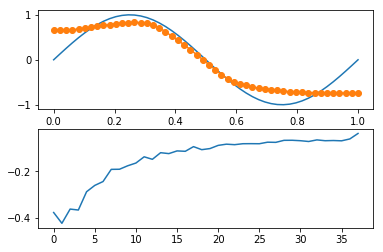

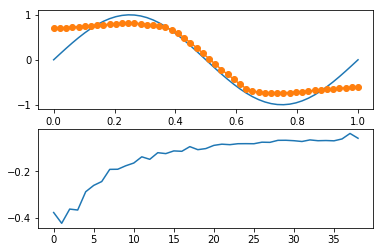

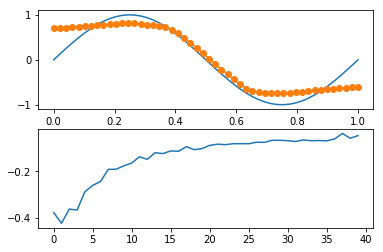

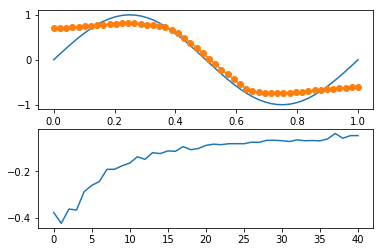

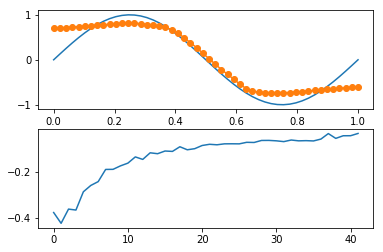

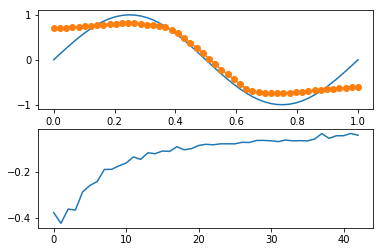

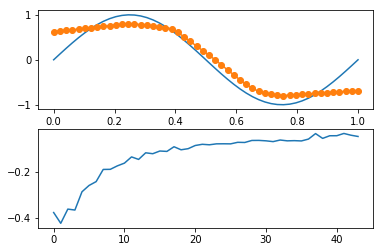

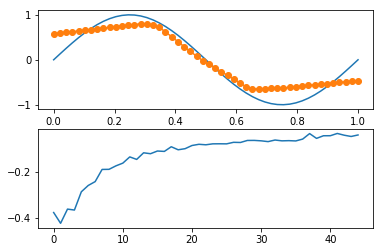

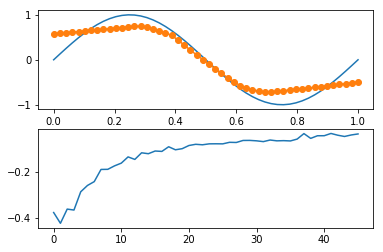

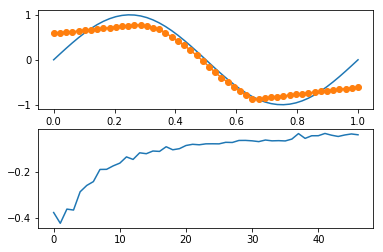

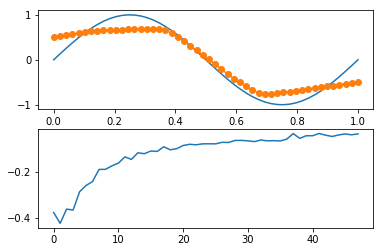

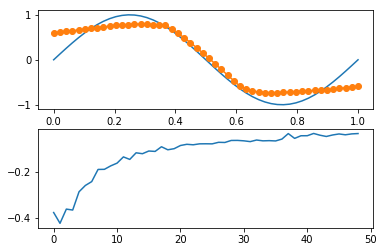

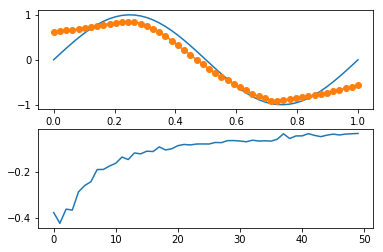

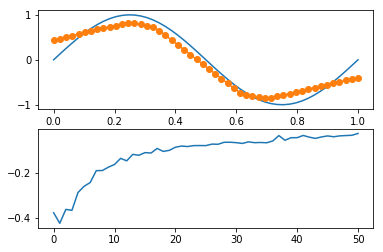

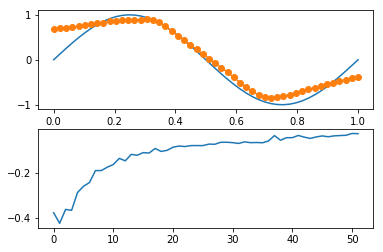

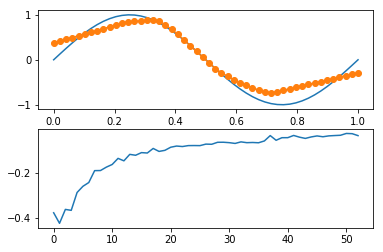

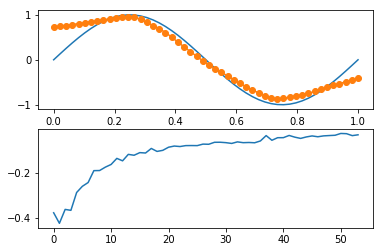

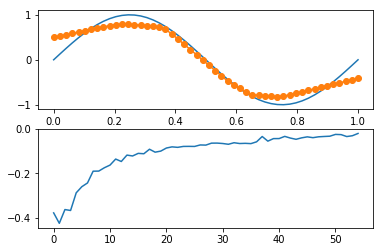

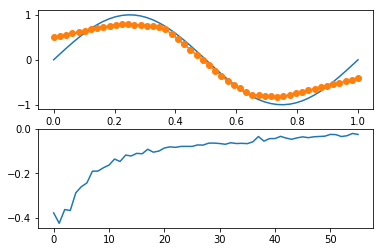

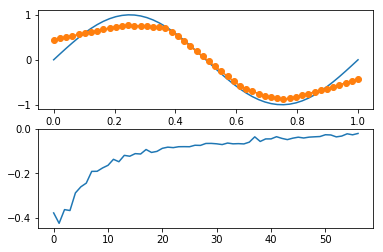

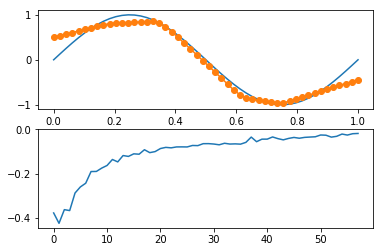

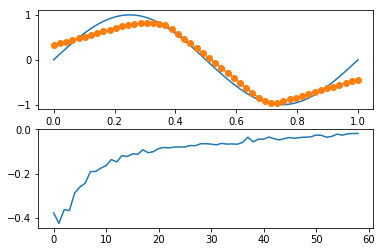

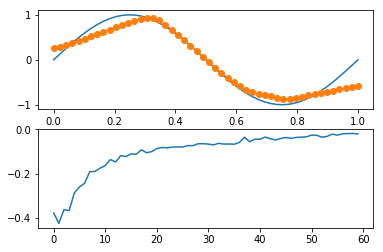

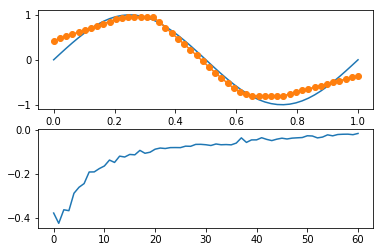

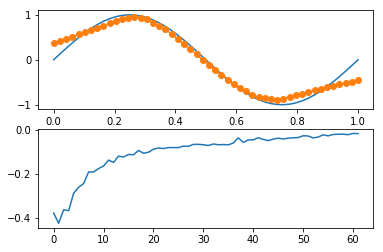

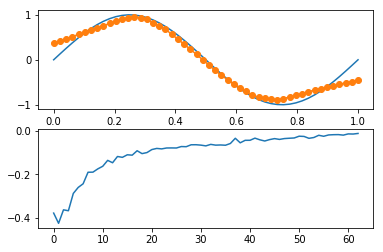

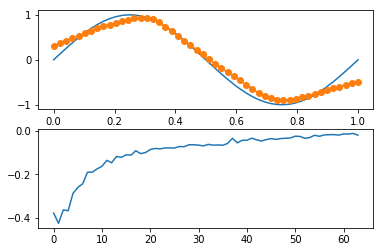

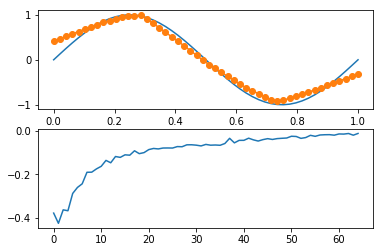

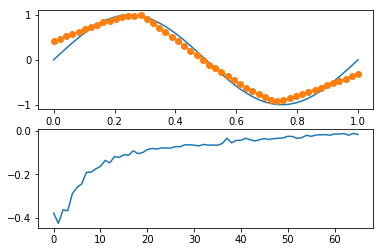

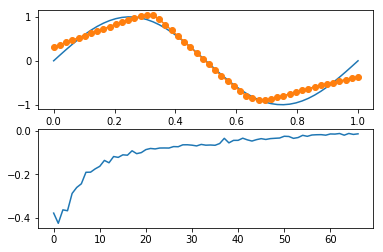

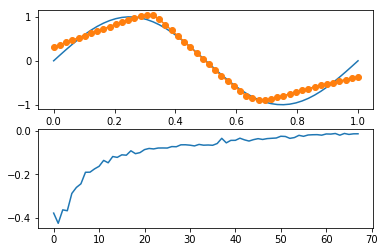

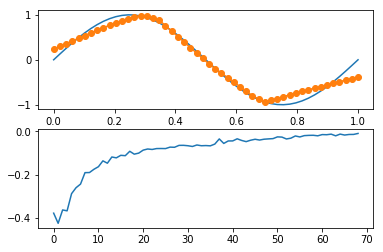

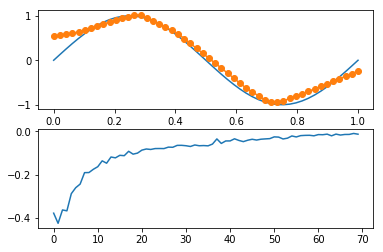

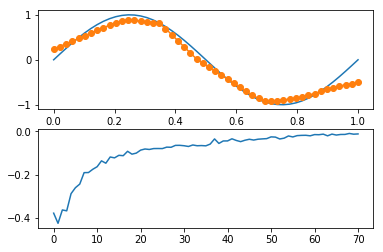

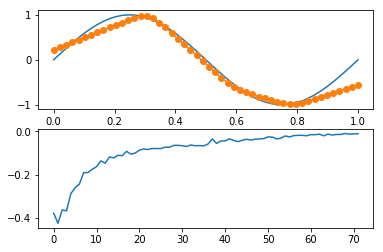

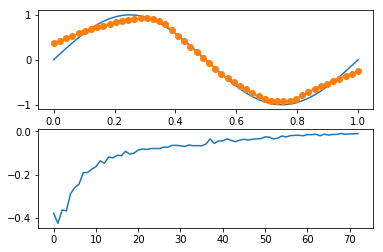

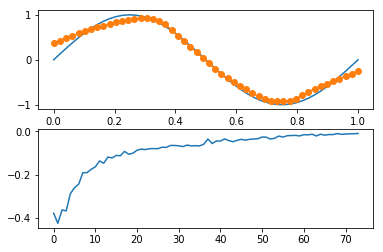

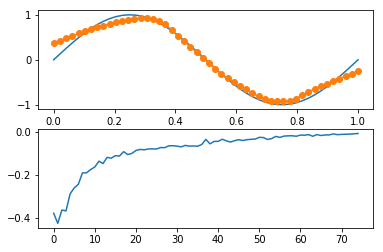

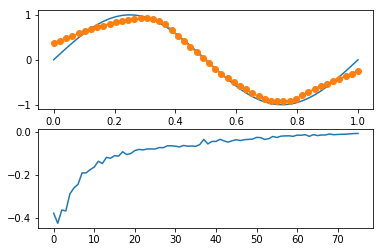

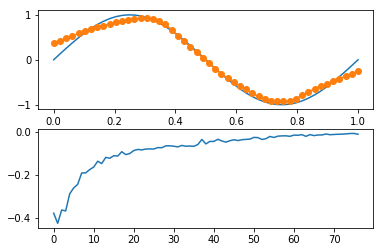

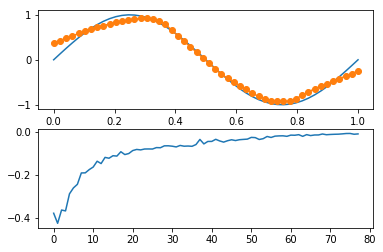

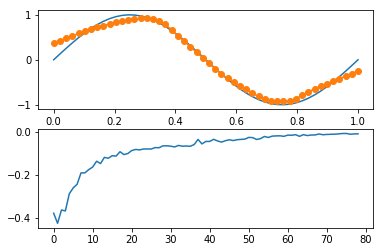

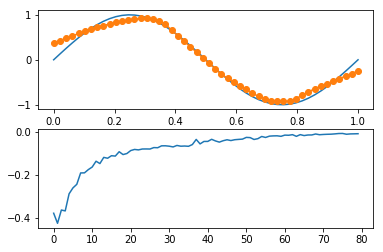

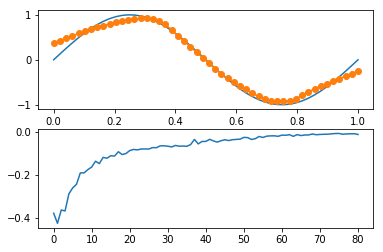

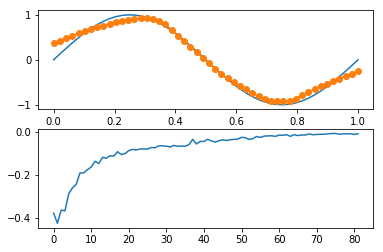

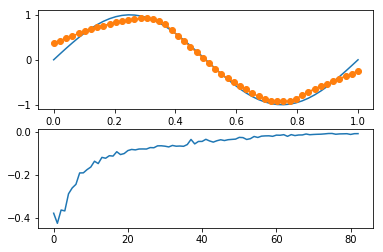

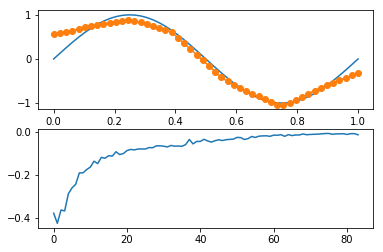

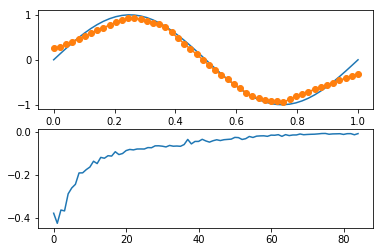

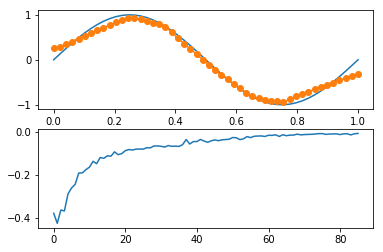

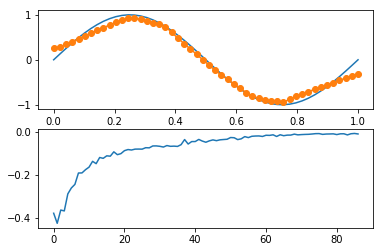

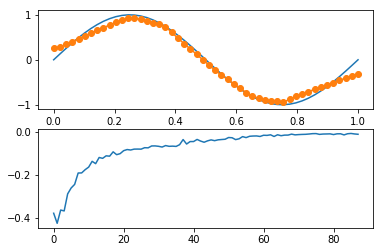

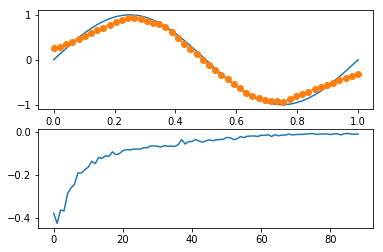

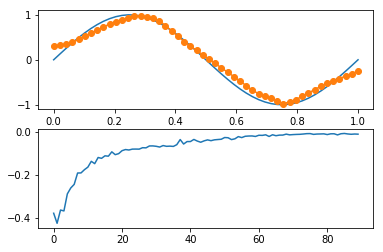

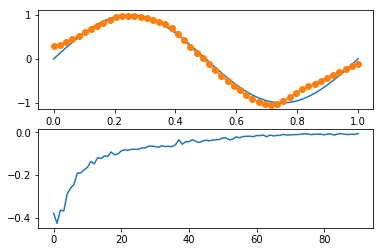

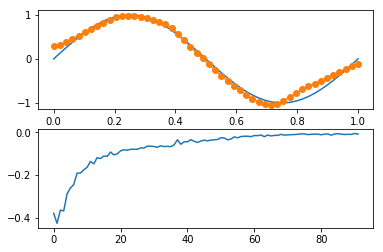

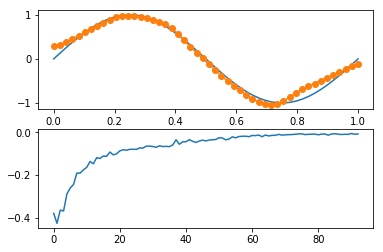

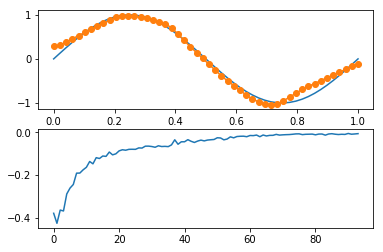

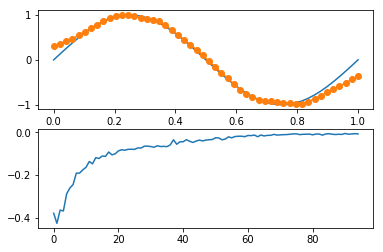

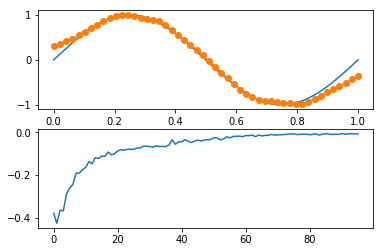

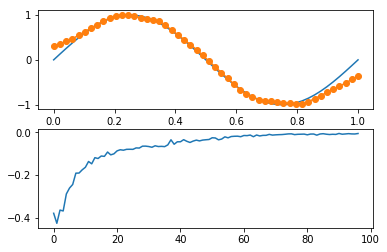

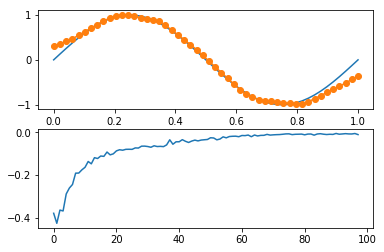

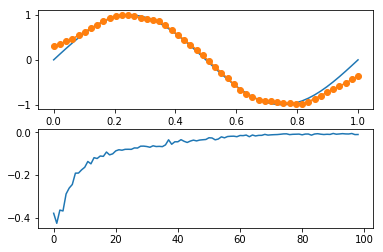

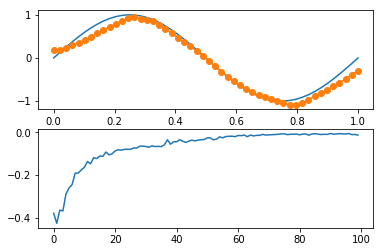

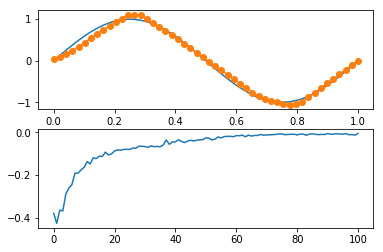

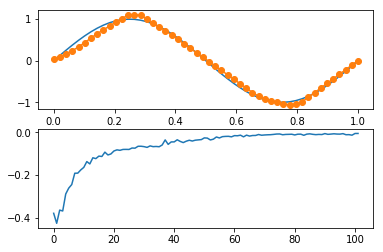

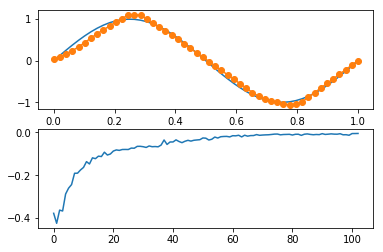

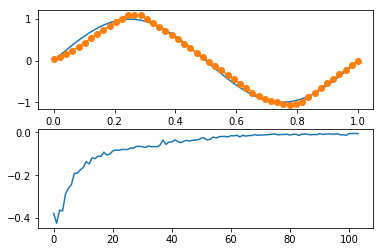

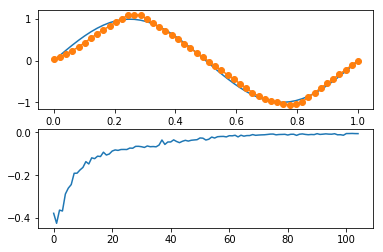

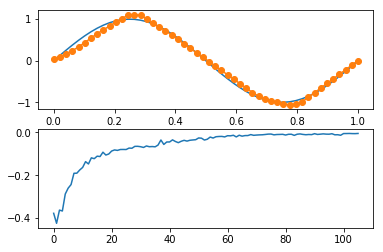

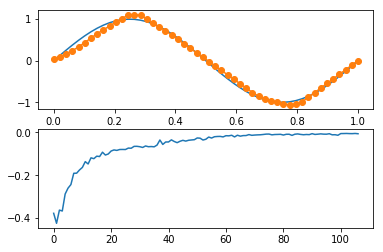

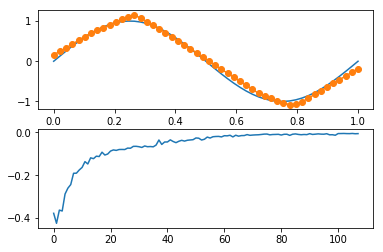

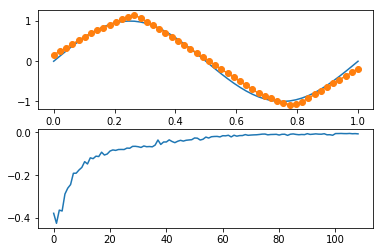

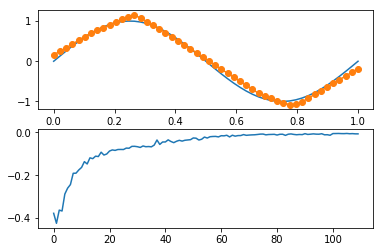

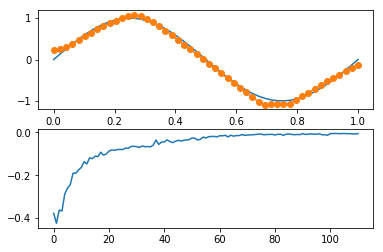

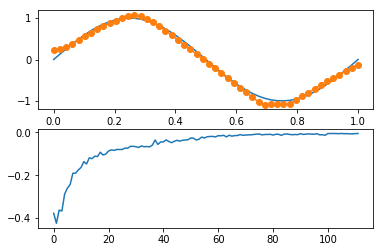

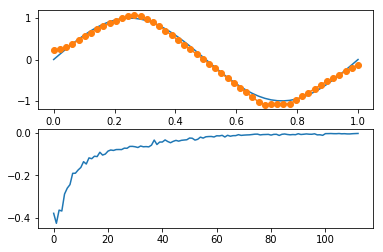

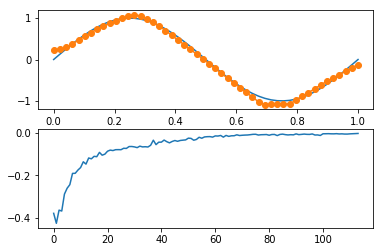

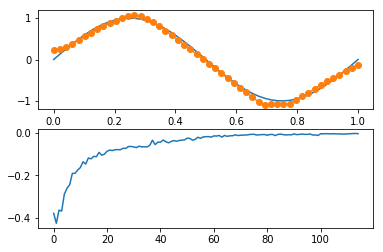

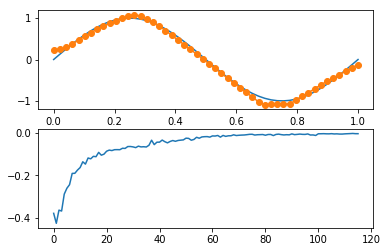

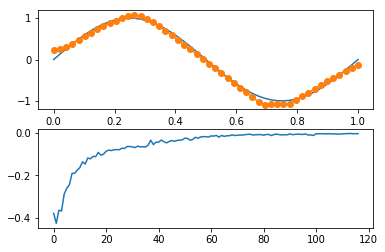

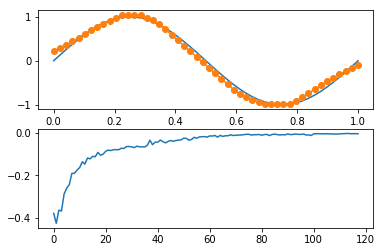

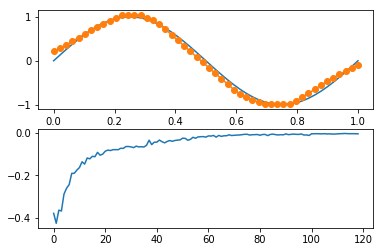

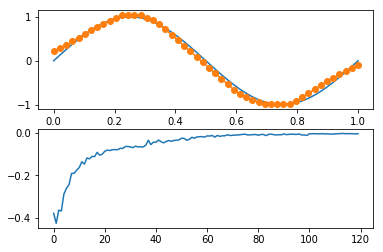

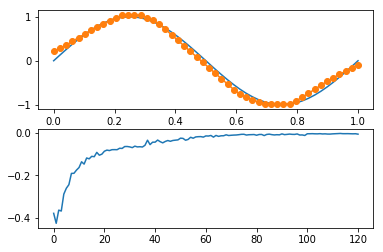

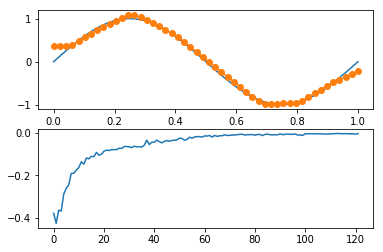

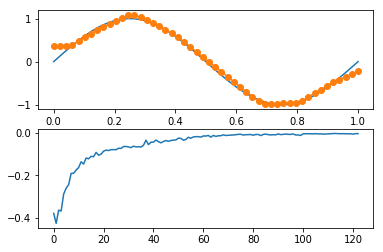

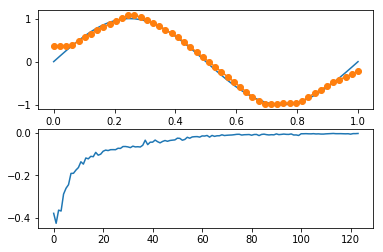

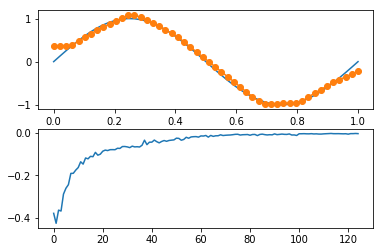

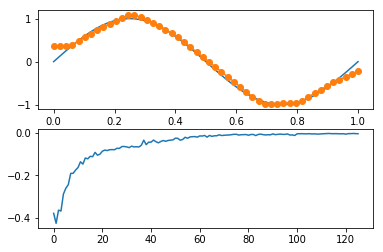

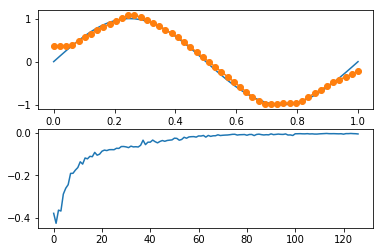

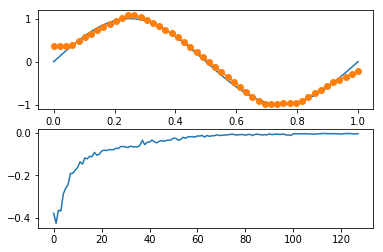

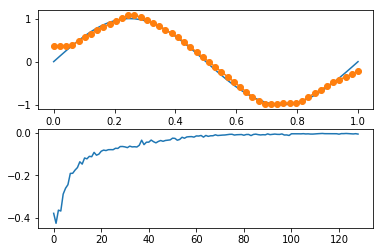

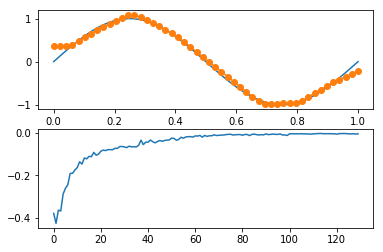

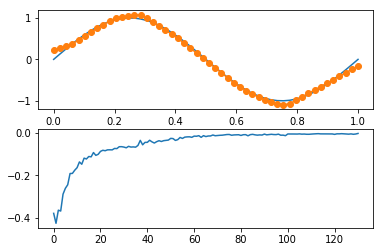

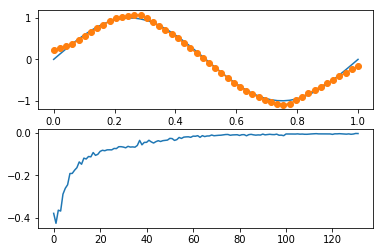

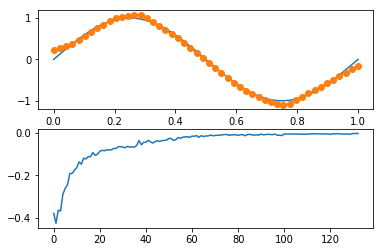

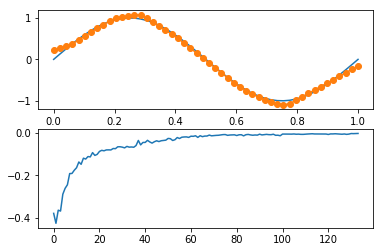

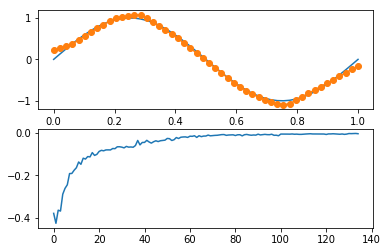

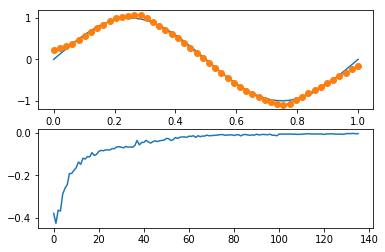

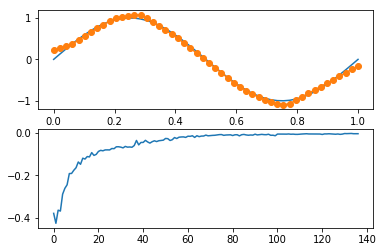

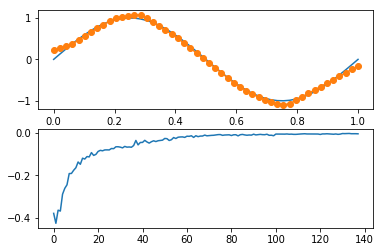

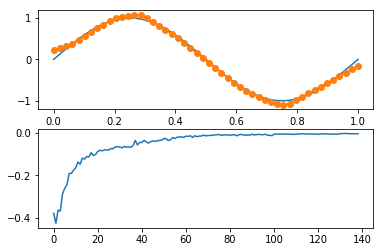

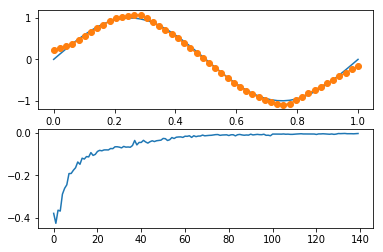

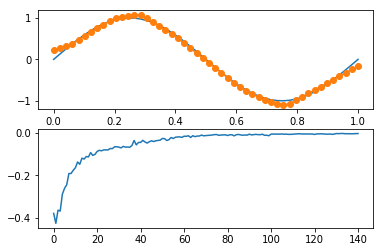

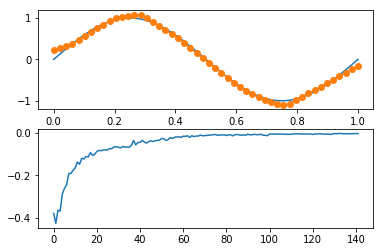

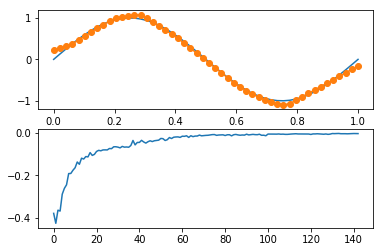

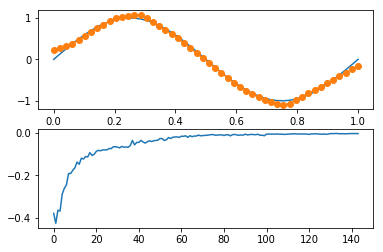

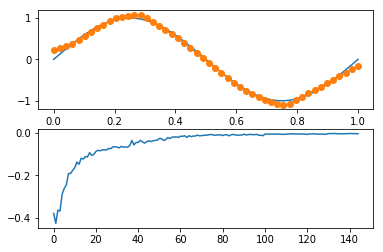

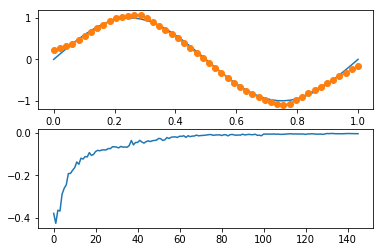

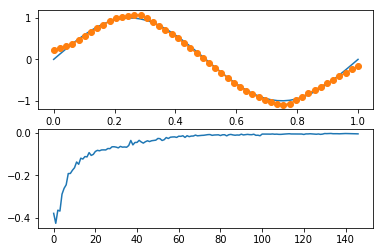

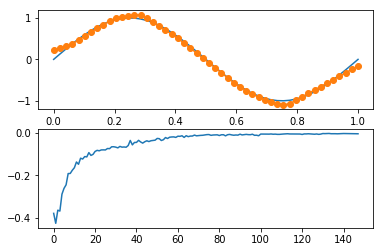

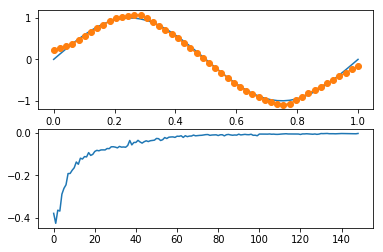

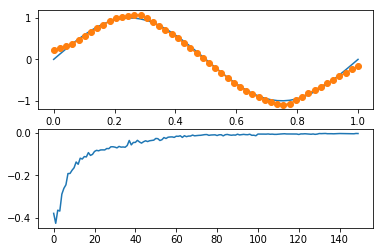

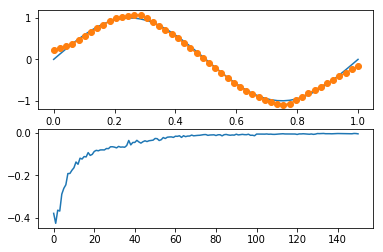

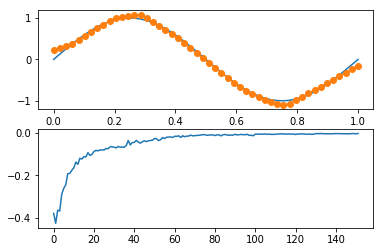

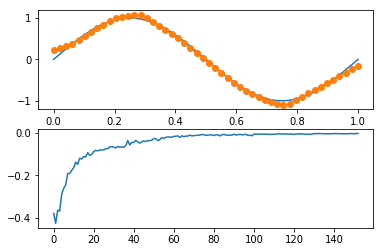

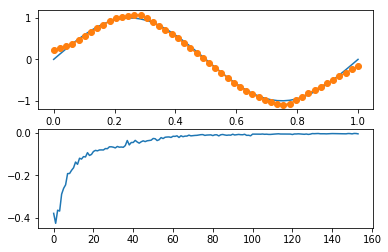

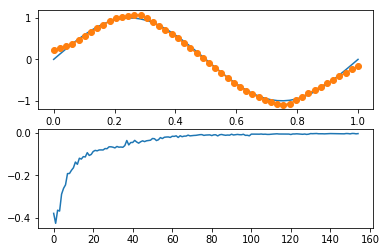

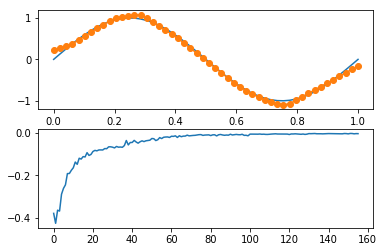

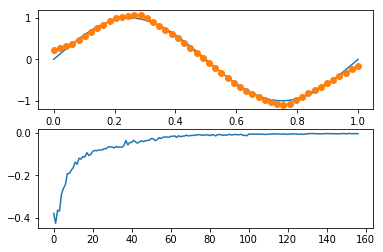

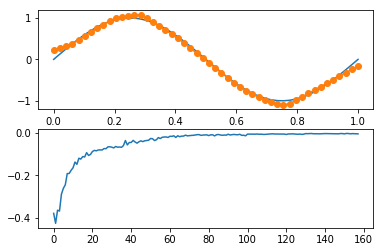

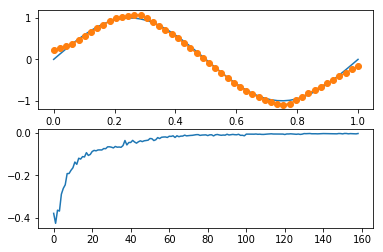

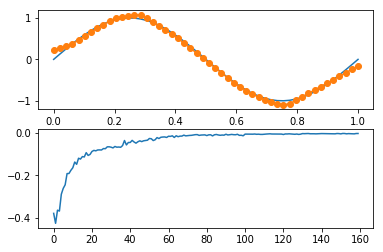

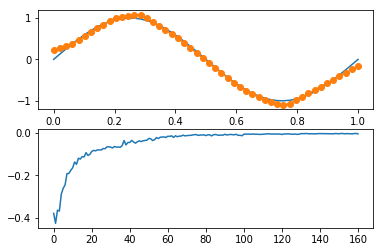

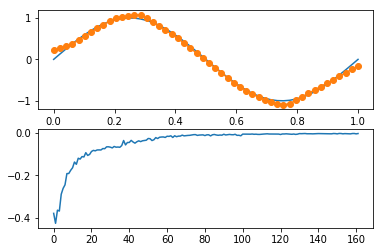

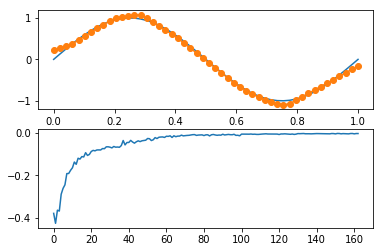

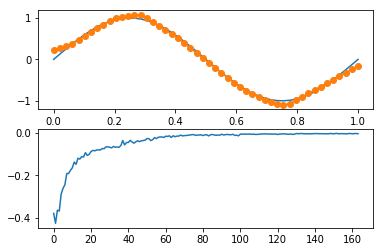

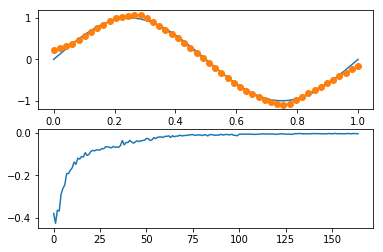

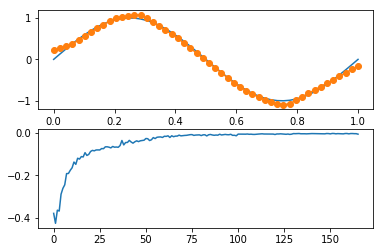

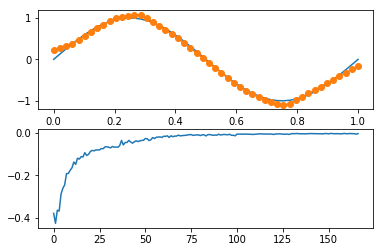

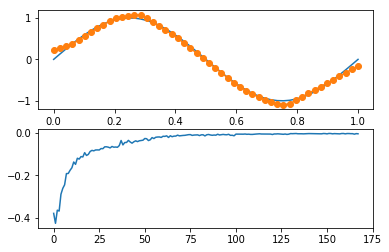

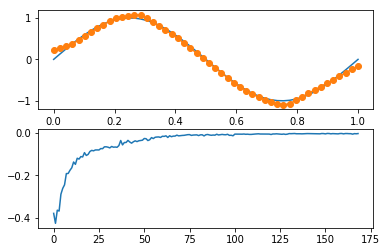

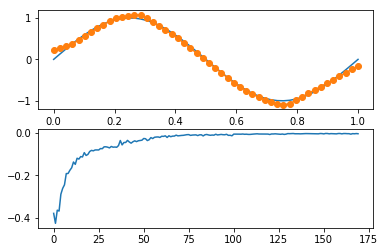

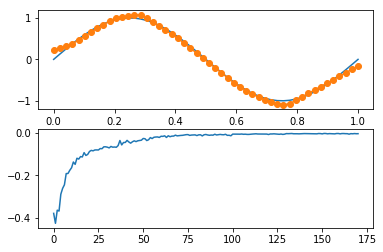

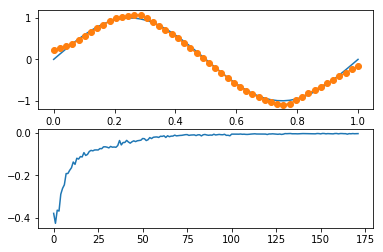

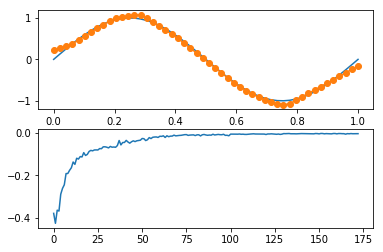

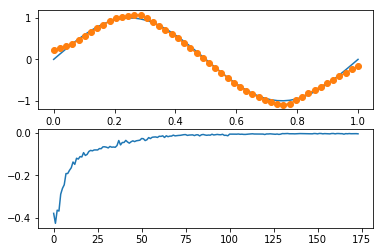

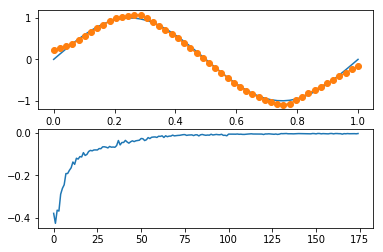

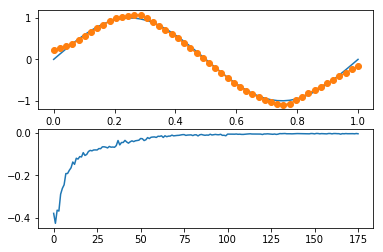

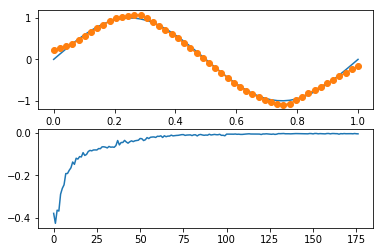

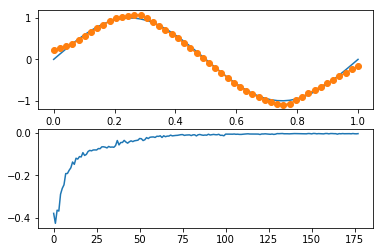

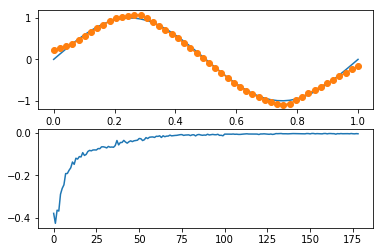

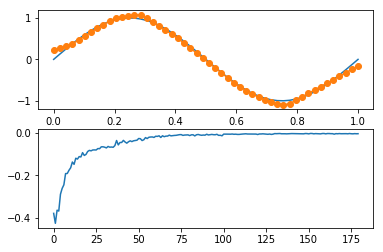

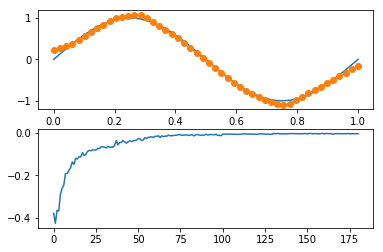

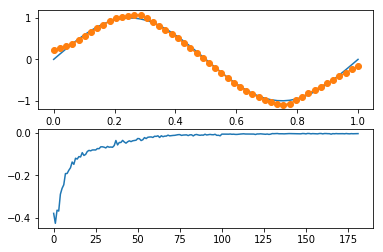

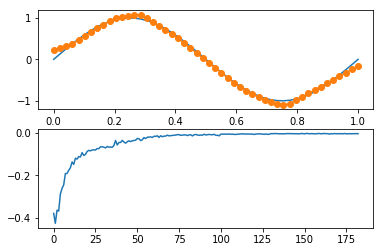

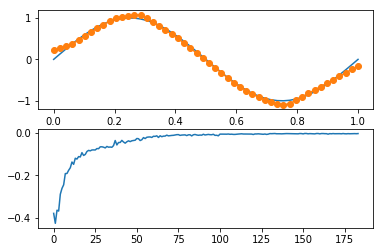

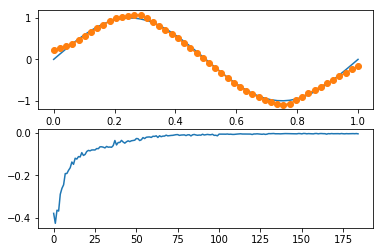

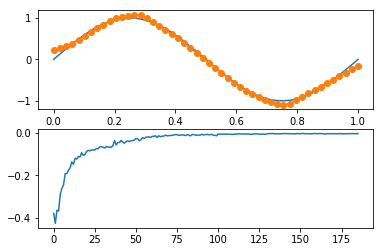

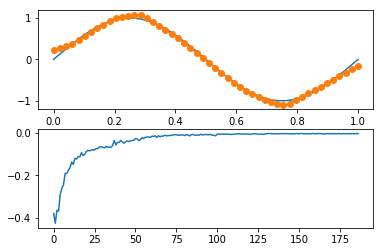

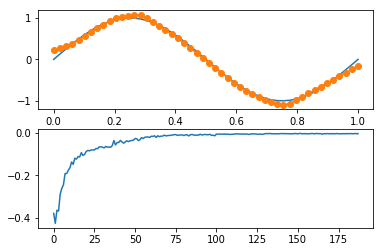

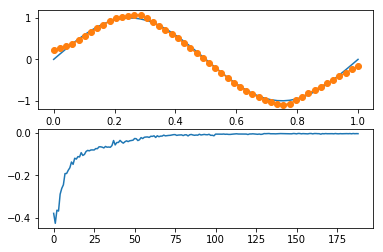

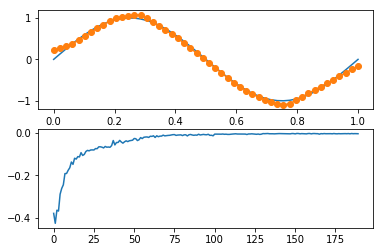

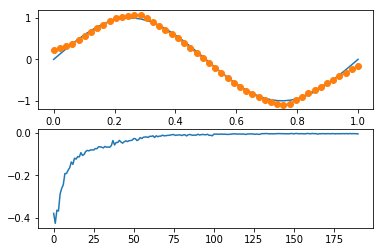

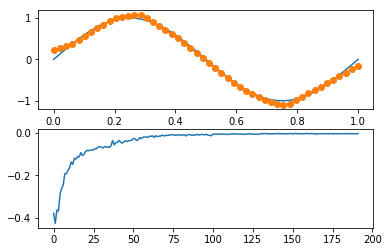

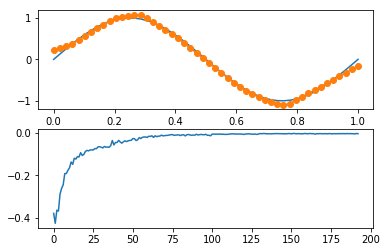

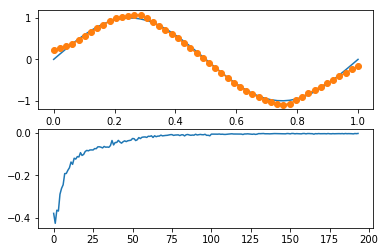

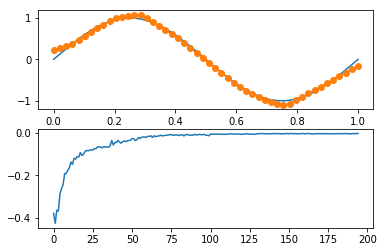

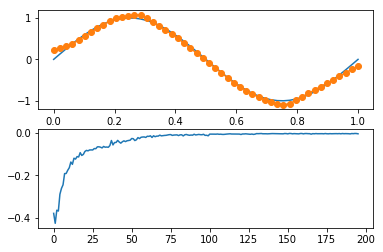

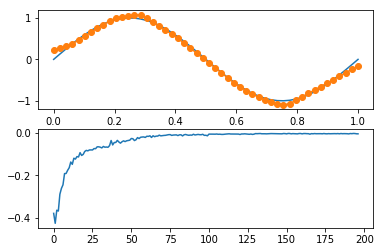

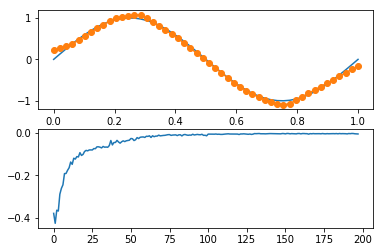

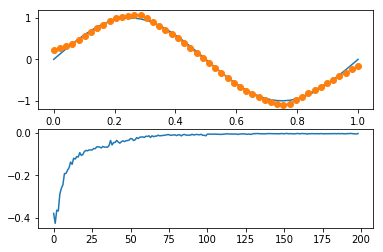

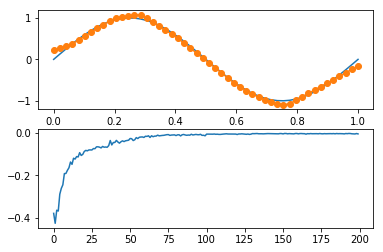

<Figure size 432x288 with 0 Axes>

In [272]:
#function to create organism
organism_creator = lambda : Organism(dimensions=[1,16,16,16,1],output='linear')
#function the neural network is going to learn
true_function = lambda x:np.sin(2*np.pi*x)
#contruct the cost function for optimization
loss_function = lambda y_true,y_estimate:np.mean((y_true-y_estimate)**2)

def get_loss(organism, replicates=1):
    '''
    Randomly generate data between [0,1]. Then use the organism to estimate the value. 
    Next, return the fitness score of the organism. 
    '''
    X = np.random.random((replicates,1))
    y_true = true_function(X)
    prediction = organism.predict(X)
    loss = loss_function(y_true,prediction)
    return -loss
#obtain the score of the organism
scoring_function = lambda organism: get_loss(organism,replicates=100)
#Create the ecosystem
ecosystem = Ecosystem(organism_creator,scoring_function,
                     population_size=100,holdout=0.1,mating=True)
#Save the best organism score in each generation
best_organism, best_organism_score = ecosystem.get_best_organism(include_reward=True)
best_organism_scores = [best_organism_score]
#Run the generations
generations = 200
for i in range(generations):
    ecosystem.generation()
    best_organism, reward = ecosystem.get_best_organism(include_reward=True)
    best_organism_scores.append(reward)
    
    X_test = np.array([np.linspace(0,1)]).T
    y_true = true_function(X_test)
    y_pred = best_organism.predict(X_test)
    
    fig, axs = plt.subplots(2)
    axs[0].plot(X_test,y_true)
    axs[0].plot(X_test,y_pred,marker='o')
    axs[1].plot(best_organism_scores)
    display.display(plt.gcf())
    display.clear_output(wait=True)


